# GPU kernel

## Import Package

In [1]:
using CUDA
# using CUDAdrv
using BenchmarkTools

# Hardware identify

Julia source code:https://github.com/JuliaGPU/CUDA.jl/blob/47a87c64ef72c3e9e3ee00e4110641f24df3336a/lib/cudadrv/devices.jl#L76-L80

CUDA C ref: http://developer.download.nvidia.com/compute/cuda/2_3/toolkit/docs/online/group__CUDA__TYPES_g3b9f561d2a42733dde99b2cedcaa413a.html#g3b9f561d2a42733dde99b2cedcaa413a


In [2]:
myGPU=CUDA.CuDevice(0)
print("My GPU: $(CUDA.name(myGPU))\n")
print("Capability: $(CUDA.capability(myGPU))\n")
print("Memmory: $(CUDA.totalmem(myGPU))\n\n")

print("MultiprocessorCount(SMs):$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT))\n\n") 

print("Max thread in each block\n")
print("MaxThreadPerBlock:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK ))\n")
print("MaxBlockDim_X:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X))\n") 
print("MaxBlockDim_Y:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Y))\n") 
print("MaxBlockDim_Z:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Z))\n\n") 

print("GridDim = BlockDim*NumBlock\n")
print("MaxGridDim_X:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X))\n")
print("MaxGridDim_Y:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Y))\n")
print("MaxGridDim_Z:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Z))\n\n")

print("SharedMem:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_SHARED_MEMORY_PER_BLOCK)/1024) kbytes\n")

print("Warp in threads:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_WARP_SIZE )) \n")
print("MaxRegister/block: $(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_MAX_REGISTERS_PER_BLOCK))\n")    
print("Registered/block:$(CUDA.attribute(myGPU,CUDA.CU_DEVICE_ATTRIBUTE_REGISTERS_PER_BLOCK ))\n")


# print("Warp in threads:$(CUDA.attribute(myGPU,CUDA.))\n)

My GPU: GeForce RTX 2060 SUPER
Capability: 7.5.0
Memmory: 8589934592

MultiprocessorCount(SMs):34

Max thread in each block
MaxThreadPerBlock:1024
MaxBlockDim_X:1024
MaxBlockDim_Y:1024
MaxBlockDim_Z:64

GridDim = BlockDim*NumBlock
MaxGridDim_X:2147483647
MaxGridDim_Y:65535
MaxGridDim_Z:65535

SharedMem:48.0 kbytes
Warp in threads:32 
MaxRegister/block: 65536
Registered/block:65536


In [5]:
CUDA.attribute(myGPU,CUDA.deviceQuery)

UndefVarError: UndefVarError: deviceQuery not defined

## Use parallel in of multi-core in GPU
### 1. Write function
Rule 
- GPU function must return nothing (don't forget "!" after function name)
- Input variable must be "CuArrays"
  Convert using aCuArr=CuArray(a)
- Please keep in mind, Convert variable from RAM to GPU RAM are slowly. Don't     place convert part in loop
- Frequency of GPU's core slower than CPU's core, We take benefit from GPU's core via a large number of core instead of frequncy speed 

In [3]:
function printThreadGPU!(N)
    index=threadIdx().x
    stride=blockDim().x
    blockID=blockIdx().x
#     N=length(y)
    @cuprintln("blockSize(nThreads):$stride, blockID:$blockID, threadID:$index")
#     @cuprint("i:$(index:stride:N)")
    for i=index:stride:N
        # Doing task
        # output[i]=...
    end

    return nothing
end

printThreadGPU! (generic function with 1 method)

### 2. Understanding "threads and block"
- Number of threads

CPU: nthreads()

GPU: blockDim()
- Threads id

CPU: threadid()

GPU: threadIdx()
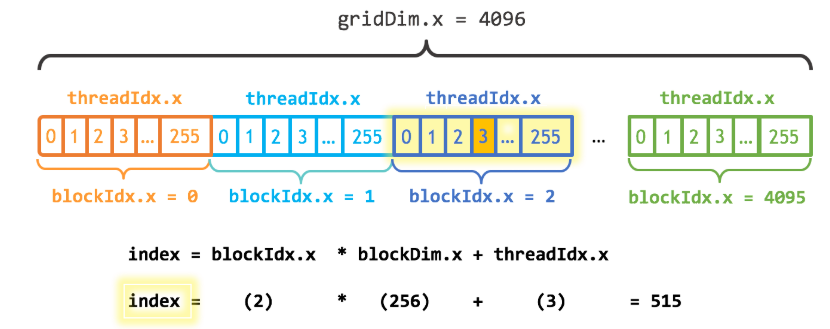

### Call GPU function with threads=1, blocks=1 

In [32]:
N=7
@cuda printThreadGPU!(N)
synchronize()

blockSize(nThreads):1, blockID:1, threadID:1


### Call GPU function with specifics threads
*synchronize() is additional, use for let @cuprint work correctly !.   

In [33]:
@cuda threads=5 printThreadGPU!(N)
synchronize()

blockSize(nThreads):5, blockID:1, threadID:1
blockSize(nThreads):5, blockID:1, threadID:2
blockSize(nThreads):5, blockID:1, threadID:3
blockSize(nThreads):5, blockID:1, threadID:4
blockSize(nThreads):5, blockID:1, threadID:5


# Single CPU vs GPU 

In [7]:
function add_cpu!(y,x)
    y=y+x;
    return nothing
end

function add_gpu!(y, x)
    #  data        1 2 3 4 ... 256  257 258 259 260 ... 512   513 514
    # blockDim=256
    # threadidx.x  0 1 2 3 ... 255   0   1   2   3  ... 255    0   1   2 3 ... 255
    # blockIdx.x         1                     2                         3

    # threadID, but thread of GPU assign by 3 dim array (x,y,z)
    # index = 1, 2, 3, ..., threads
    index = threadIdx().x
    # stride like step of nthreads
    stride = blockDim().x # equal to threads=256 (assign when called funciton) 
    
    for i = index:stride:length(y)
        # blockId    threadsIdx    loop
        #    1           1         i = 1,257,513,..., i(n-1) + nthreads
        #    1           2         i = 2,258,514,..., i(n-1) + nthreads
        #    1           3         i = 3,259,515,...
        #   ...
        #    1          256        i = 256,512,768,...
        # @inbounds y[i] += x[i]
        y[i] += x[i]
    end
    return nothing
end

add_gpu! (generic function with 1 method)

### 2. Call function and Divided task to multi-core of GPU 
Multi-core of GPU will improve only task with a large array >> 10,000 dimension CPU add is faster

In [37]:
nThreads=256 # enable thread of GPU for parallel processing

n=10000
a=fill(1.0,n)
b=fill(2.0,n)
# acu=CUDA.fill(1.0f0,n)
# bcu=CUDA.fill(2.0f0,n)

# CPU add
print("time CPU")
@btime add_cpu!(a,b)

# call function and divided task to 256 threads
# usin @cuda task in function must scalar operator
# thread=1 >> add_gpu!(b,a)
# @cuda threads=nThreads add_gpu!(bcu,acu)

print("time function GPU @CUDA")
acu=CuArray(a)
bcu=CuArray(b)
@btime begin
    @cuda add_gpu!(bcu,acu)
end

# we should transform array to CuArray outside the loop
print("time GPU + Convert to CUDA Arrays")
@btime begin
    acu=CuArray(a)
    bcu=CuArray(b)
    @cuda threads=nThreads add_gpu!(bcu,acu)
end

print("time funciton GPU setThreads")
acu=CuArray(a)
bcu=CuArray(b)
@btime begin
    @cuda threads=nThreads add_gpu!(bcu,acu)
end

print("time GPU2 @CUDA")
acu=CuArray(a)
bcu=CuArray(b)
@btime begin
    @cuda add_gpu2!(bcu,acu)
end

print("time operate CuArray")
@btime ccu=acu+bcu;

# diff=Array(bcu)-a

time CPU  6.850 μs (2 allocations: 78.20 KiB)
time function GPU @CUDA  8.700 μs (57 allocations: 1.72 KiB)
time GPU + Convert to CUDA Arrays  112.099 μs (76 allocations: 2.19 KiB)
time funciton GPU setThreads  9.600 μs (62 allocations: 1.88 KiB)
time GPU2 @CUDA  9.200 μs (57 allocations: 1.72 KiB)
time operate CuArray  12.500 μs (77 allocations: 2.61 KiB)


Try again with 1,000,000 dimension >> GPU time is constanstly as 10,000 dimension

In [ ]:
nThreads=256 # enable thread of GPU for parallel processing

n=1000000
a=fill(1.0,n)
b=fill(2.0,n)
# acu=CUDA.fill(1.0f0,n)
# bcu=CUDA.fill(2.0f0,n)

# CPU add
print("time CPU")
@btime add_cpu!(a,b)

print("time function GPU @CUDA")
acu=CuArray(a)
bcu=CuArray(b)
@btime begin
    @cuda add_gpu!(bcu,acu)
end

print("time funciton GPU setThreads")
acu=CuArray(a)
bcu=CuArray(b)
@btime begin
    @cuda threads=nThreads add_gpu!(bcu,acu)
end

print("time operate CuArray")
@btime ccu=acu+bcu;

# diff=Array(bcu)-a

### Specific GPU Numblock

In [17]:
function printThreadGPU2!(N)
    #                         setWhenCalled=256       
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    #        Input threads    numBlock
    stride = blockDim().x * gridDim().x
    blockID = blockIdx().x
    
    @cuprintln("blockSize(nThreads):$stride, blockID:$blockID, threadID:$index")
    for i=index:stride:N
        # Doing task
        # output[i]=...
    end

    return nothing
end

printThreadGPU2! (generic function with 1 method)

In [18]:
N=7
#  nThreads/block 
@cuda threads=5 blocks=3 printThreadGPU2!(N)
synchronize()

blockSize(nThreads):15, blockID:1, threadID:1
blockSize(nThreads):15, blockID:1, threadID:2
blockSize(nThreads):15, blockID:1, threadID:3
blockSize(nThreads):15, blockID:1, threadID:4
blockSize(nThreads):15, blockID:1, threadID:5
blockSize(nThreads):15, blockID:3, threadID:11
blockSize(nThreads):15, blockID:3, threadID:12
blockSize(nThreads):15, blockID:3, threadID:13
blockSize(nThreads):15, blockID:3, threadID:14
blockSize(nThreads):15, blockID:3, threadID:15
blockSize(nThreads):15, blockID:2, threadID:6
blockSize(nThreads):15, blockID:2, threadID:7
blockSize(nThreads):15, blockID:2, threadID:8
blockSize(nThreads):15, blockID:2, threadID:9
blockSize(nThreads):15, blockID:2, threadID:10


In [5]:
function add_gpu2!(y, x)
    #                         setWhenCalled=256       
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    #        Input threads    
    stride = blockDim().x * gridDim().x
    
    for i = index:stride:length(y)
        # blockId    threadsIdx    loop
        #    1           1         i = 1,257,513,..., i(n-1) + nthreads
        #    1           2         i = 2,258,514,..., i(n-1) + nthreads
        #    1           3         i = 3,259,515,...
        #   ...
        #    1          256        i = 256,512,768,...
        #    2           1         i = 
        
        @inbounds y[i] += x[i]
    end
    return nothing
end

add_gpu2! (generic function with 1 method)

### n=1,000,000

In [12]:
nThreads=256 # enable thread of GPU for parallel processing

n=1000000
a=fill(1.0,n)
b=fill(2.0,n)
# acu=CUDA.fill(1.0f0,n)
# bcu=CUDA.fill(2.0f0,n)
acu=CuArray(a)
bcu=CuArray(b)

# CPU add
print("time CPU")
@btime add_cpu!(a,b)

print("time funciton GPU setThreads")
@btime begin
    @cuda threads=nThreads add_gpu!(bcu,acu)
end

print("time funciton GPU setThreads+block")
nBlock=ceil(Int,n/nThreads)
@btime begin
    @cuda threads=nThreads blocks=nBlock add_gpu2!(bcu,acu)
end

print("time operate CuArray")
@btime ccu=acu+bcu;

# diff=Array(bcu)-a



time CPU  1.700 ms (2 allocations: 7.63 MiB)
time funciton GPU setThreads  9.300 μs (62 allocations: 1.88 KiB)
time funciton GPU setThreads+block  9.200 μs (67 allocations: 2.00 KiB)
time operate CuArray  9.400 μs (78 allocations: 2.63 KiB)


### n=10,000,000

In [13]:
nThreads=256 # enable thread of GPU for parallel processing

n=10000000
a=fill(1.0,n)
b=fill(2.0,n)
# acu=CUDA.fill(1.0f0,n)
# bcu=CUDA.fill(2.0f0,n)
acu=CuArray(a)
bcu=CuArray(b)

# CPU add
print("time CPU")
@btime add_cpu!(a,b)

print("time funciton GPU setThreads")
@btime begin
    @cuda threads=nThreads add_gpu!(bcu,acu)
end

print("time funciton GPU setThreads+block")
nBlock=ceil(Int,n/nThreads)
@btime begin
    @cuda threads=nThreads blocks=nBlock add_gpu2!(bcu,acu)
end

print("time operate CuArray")
@btime ccu=acu+bcu;

# diff=Array(bcu)-a

time CPU  18.830 ms (2 allocations: 76.29 MiB)
time funciton GPU setThreads  9.800 μs (62 allocations: 1.88 KiB)
time funciton GPU setThreads+block  9.300 μs (67 allocations: 2.00 KiB)
time operate CuArray  9.400 μs (82 allocations: 2.69 KiB)


## Call GPU function in loop
### 1. Write function

In [4]:
# function GPU
function add_gpu!(y, x)

    index = threadIdx().x

    stride = blockDim().x 

    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
        
    end
    return nothing
end

# function GPU
function multiply_gpu!(y, x)

    index = threadIdx().x

    stride = blockDim().x 

    for i = index:stride:length(y)
        @inbounds y[i] = y[i] * x[i]
        
    end
    return nothing
end

multiply_gpu! (generic function with 1 method)

## 2. Call function
We try to multiply each column of a2 with vector a1

In [2]:
m=10000
n=10
a1=fill(-1,m) # vector
a2=fill(1,m,n) # matric

a1cu=CuArray(a1)
a2cu=CuArray(a2)

nThreads=256

256

Seem to be simple like this

In [12]:
row,col=size(a2cu)

for ic=1:col
    a2cuCol=a2cu[:,ic]
    @cuda threads=nThreads multiply_gpu!(a2cuCol,a1cu)
    a2cu[:,ic]=a2cuCol
end
a2cu

10000×10 CuArray{Int64,2,Nothing}:
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮           
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1

### Data a2cu not change !, Try again and do only one iterate

In [13]:
for ic=1
    a2cuCol=a2cu[:,ic]
    @cuda threads=nThreads multiply_gpu!(a2cuCol,a1cu)
    a2cu[:,ic]=a2cuCol
end
a2cu

10000×10 CuArray{Int64,2,Nothing}:
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
  ⋮              ⋮           
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1

### Now the a2cu has changed, The points is we have to wait the GPU task done before start the next task like @sync in multi-thread of CPU

In [15]:
cuMulti=CUDA.CuEvent()

CuEvent(Ptr{Nothing} @0x000000004dfa0a90, CuContext(Ptr{Nothing} @0x000000002dc4ba60))

# Euclidean distance

In [95]:
function euclidean_cpu(input,target)
    distance=sqrt.(sum((input-target).^2,dims=2))
    return distance
end

# function euclidean_gpu!(dist,input,target)
function euclidean_gpu!(dist,diff)
    
    # e.g. @cuda threads=256 funcA()
    # blockDim=256
    #  data        1 2 3 4 ... 256  257 258 259 260 ... 512   513 514
    # threadidx.x  0 1 2 3 ... 255   0   1   2   3  ... 255    0   1   2 3 ... 255
    # blockIdx.x         0                1               2

    # threadID, but thread of GPU assign by 3 dim array
    # index = 0 1 2 ... threads-1
    index = threadIdx().x
    # @cuprintf("size:%d\n",length(index))

    stride = blockDim().x # = nThreads >>
    # print("ThreadID:$index, Stride:$stride \n")
    # @cuprintf("ThreadID:%d",index)
    # @cuprintf("BlockIdx:%d\n",blockIdx().x)

    for i = index:stride:length(dist)
        
#         @inbounds dist[i,1]=((diff[i,1].^2)+(diff[i,2].^2)+(diff[i,3].^2))^0.5
#       @inbounds dist[i,1]=sqrt((diff[i,1].^2)+(diff[i,2].^2)+(diff[i,3].^2))
      dist[i,1]=sqrt((diff[i,1].^2)+(diff[i,2].^2)+(diff[i,3].^2))  
#         @inbounds dist[i,1]=sqrt(((target[i,1]-input[i,1]).^2)+((target[i,2]-input[i,2]).^2)+((target[i,:]-input[i,:]).^2))
    end
    return nothing

end

euclidean_gpu! (generic function with 2 methods)

In [96]:
dist_cu=CUDA.zeros(Float64,size(input,1),1); 
diff_cu=target_cu-input_cu
@cuda threads=nThreads euclidean_gpu!(dist_cu,diff_cu)

In [109]:
n=100000
input=rand(n,3);
target=rand(n,3);
@btime euclidean_cpu(input,target)

input_cu=CuArray(input)
target_cu=CuArray(target)
diff_cu=target_cu-input_cu
dist_cu=CUDA.zeros(Float64,size(input,1),1); 
nThreads=512
@btime @cuda threads=nThreads euclidean_gpu!(dist_cu,diff_cu)

  1.208 ms (14 allocations: 6.10 MiB)
  11.400 μs (62 allocations: 1.98 KiB)


Check diff of results

In [111]:
@time euclidean_cpu(input,target)

@time @cuda threads=nThreads euclidean_gpu!(dist_cu,diff_cu)

  0.001629 seconds (14 allocations: 6.104 MiB)
  0.000101 seconds (64 allocations: 2.031 KiB)


In [97]:
dist_cpu=euclidean_cpu(input,target)

100000×1 Array{Float64,2}:
 0.47538386676211264
 0.5842694097400253
 0.8050918664445711
 0.9334740348977845
 0.31912525052637414
 0.4352356701952695
 1.120644611401131
 0.4907888826951998
 0.6253574486880473
 0.7593709156221959
 0.5482526445761633
 0.9655495129802777
 0.45786400131984717
 ⋮
 0.5403560583744129
 0.3749160330953853
 0.9279846190395261
 0.776252340536754
 0.8087888172713317
 0.6877708898233947
 0.2568994518352382
 1.0531098858096044
 0.6479331588368223
 0.29442564764234386
 0.5077722189892483
 0.970509159803179

In [98]:
@cuda threads=nThreads euclidean_gpu!(dist_cu,diff_cu)
dist_cu

100000×1 CuArray{Float64,2,Nothing}:
 0.47538386676211264
 0.5842694097400253
 0.8050918664445711
 0.9334740348977845
 0.31912525052637414
 0.4352356701952695
 1.120644611401131
 0.4907888826951998
 0.6253574486880473
 0.7593709156221959
 0.5482526445761633
 0.9655495129802777
 0.4578640013198472
 ⋮
 0.5403560583744129
 0.3749160330953853
 0.9279846190395261
 0.776252340536754
 0.8087888172713317
 0.6877708898233947
 0.2568994518352382
 1.0531098858096044
 0.6479331588368223
 0.29442564764234386
 0.5077722189892483
 0.9705091598031789

In [108]:
diffMethod=dist_cpu-Array(dist_cu)
sum(abs.(diffMethod))

6.492167914373681e-13

In [94]:
target-input - Array(diff_cu)

100000×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0